<center><h1> Flappy Bird Assignment </center></h1>

# I. Set up of the environment

In [105]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/pip-req-build-jtzd7pxy
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/pip-req-build-jtzd7pxy
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os, sys
import gymnasium as gym
import time
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import sys
import text_flappy_bird_gym
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    

There are two distinct versions of the environ-
ment available, one that returns as an observation the complete screen render of
the game (TextFlappyBird-screen-v0 ) and another one that returns the distance
of the player from the center of the closest upcoming pipe gap (TextFlappyBird-
v0 ) along the two axes (x, y).

In [3]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
print(env.action_space.n)

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


2
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-5)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-6)
Text Flappy Bird!
Score: 0
----------------------
[   

# Utils functions

In [1]:
from agent import BaseAgent

In [4]:
def plot_fb_values(agent,agent_name):
    def get_Z(x, y, agent):
        if (x,y) in agent.state_dict.keys():
            
            return np.max(agent.q[agent.state_dict[(x,y)]])
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 13)
        y_range = np.arange(-11, 12)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
        ax.set_xlabel('X-axis distance  from Pipe')
        ax.set_ylabel('Y-axis distance from Pipe')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(agent_name + ' State Value Plot')
    get_figure(ax)
    
    
def plot_policy(agent,agent_name):
    def get_Z_with_unexplored(x, y,agent):
        if (x,y) in agent.state_dict.keys():
            return np.argmax(agent.q[agent.state_dict[(x,y)]])
        else:
            return -1 #define a value for Z to visualize unexplored areas
    
    def get_figure(ax):
        x_range = np.arange(0, 13)
        y_range = np.arange(-12, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z_with_unexplored(x,y, agent) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape) 
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2'))
        plt.xticks(x_range) 
        plt.yticks(np.arange(23), range(-11, 12, 1)) 
        plt.gca().invert_xaxis() 
        ax.set_xlabel('X distance from Pipe') 
        ax.set_ylabel('Y distance from Pipe') 

        ax.grid(color='w', linestyle='-', linewidth=1) 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1) 
        cbar = plt.colorbar(surf, boundaries=[-1.5,-0.5,0.5,1.5], ticks=[-1,0,1], cax=cax) 
        cbar.ax.set_yticklabels(['Unexplored Region', 'Idle','Flap'])

    
    fig = plt.figure(figsize=(10, 10)) 
    ax = fig.add_subplot(111)
    ax.set_title(agent_name + ' Policy')
    get_figure(ax)
    plt.show() # show the plot
    

# II. Agents implementation

Within the scope of this assignment you are asked to implement and compare
two agents that can solve one of the two versions of the TextFlappyBird-v0 envi-
ronment (or both). Specifically you will have to implement firstly a Monte Carlo
based agent of your choice and secondly the Sarsa(λ) agent that is described in
section 7.5 of the Reinforcement Learning Book

# A- MC policy control

## 1- Implementation

In [5]:
import numpy as np
from collections import defaultdict

class MonteCarloAgent:
    def agent_init(self, agent_init_info):
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.q = np.zeros((self.num_states, self.num_actions))
        self.scores = []
        self.state_dict = {}

    def generate_episode_from_Q(self, env, epsilon, max_score = 300):
        episode = []
        state = env.reset()[0]
        score = 0
        while True:
            if state in self.state_dict.keys():
                state_idx = self.state_dict[state]
            else:
                self.state_dict[state] = len(self.state_dict)
                state_idx = self.state_dict[state]
            action = self.rand_generator.choice(
                np.arange(self.num_actions), p=self.get_probs(self.q[state_idx,:], epsilon)) \
                     if state in self.q else env.action_space.sample()
            next_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            score += info['score']
            if done:
                break
            if  score > max_score:
                break
        self.scores.append(score)
        return episode

    def get_probs(self, Q_s, epsilon):
        policy_s = np.ones(self.num_actions) * epsilon / self.num_actions
        best_a = self.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / self.num_actions)
        return policy_s

    def update_Q(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.discount**i for i in range(len(rewards) + 1)])
        for i, state in enumerate(states):
            if state in self.state_dict.keys():
                state_idx = self.state_dict[state]
            else:
                self.state_dict[state] = len(self.state_dict)
                state_idx = self.state_dict[state]
            old_Q = self.q[state_idx][actions[i]]
            future_reward = np.sum(rewards[i:] * discounts[:-(1 + i)])  # Calculate total discounted reward from current time step
            self.q[state_idx][actions[i]] = old_Q + self.step_size * (future_reward - old_Q)

    def train(self, env, num_episodes, eps_start, eps_decay, eps_min, max_score = 400):
        self.rewards = []
        epsilon = eps_start
        for i_episode in range(1, num_episodes + 1):
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            # set the value of epsilon
            epsilon = max(epsilon * eps_decay, eps_min)
            # generate an episode by following epsilon-greedy policy
            episode = self.generate_episode_from_Q(env, epsilon, max_score = max_score)
            self.rewards.append(sum([ep[2] for ep in episode]))
            # update the action-value function estimate using the episode
            self.update_Q(episode)
        # determine the policy corresponding to the final action-value function estimate
        return self.q, self.rewards, self.scores

    def argmax(self, q_values):
        top = float("-inf")
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

In [6]:
# Create the environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Initialize and train the agent
montecarlo_agent = MonteCarloAgent()
montecarlo_agent.agent_init({"num_actions": env.action_space.n, "num_states": env.observation_space[0].n * env.observation_space[1].n , "step_size": 0.02, "discount": 1.0, "seed": 0})
q_values, rewards , scores = montecarlo_agent.train(env, num_episodes=10000, eps_start=1.0, eps_decay=0.99999, eps_min=0.05, max_score = 6000)


Episode 10000/10000.

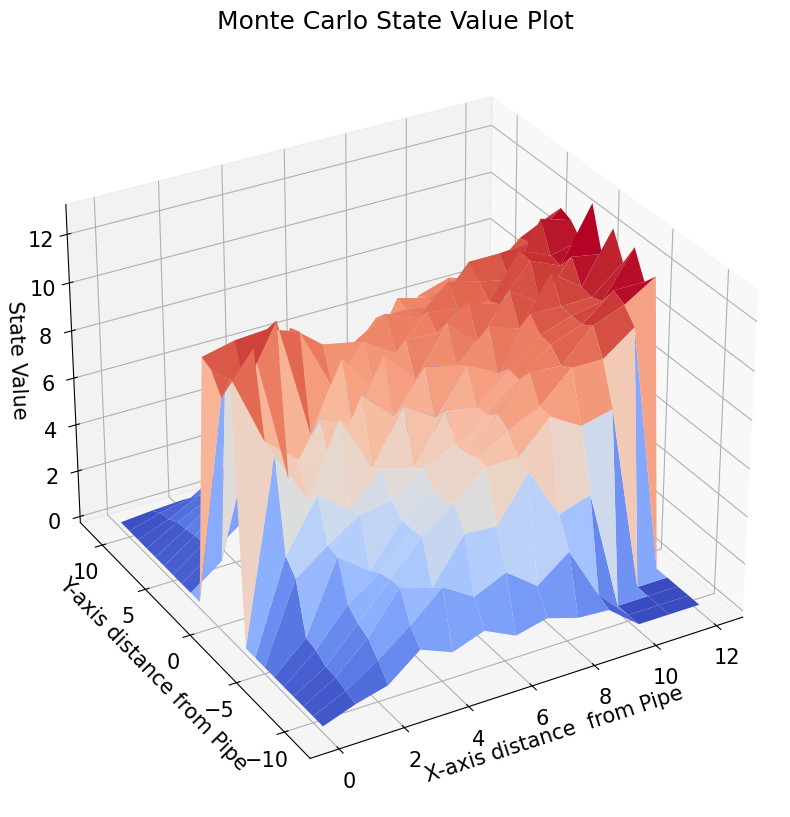

In [359]:
plot_fb_values(montecarlo_agent, 'Monte Carlo')

In [361]:
print('Score max',np.max(scores))

Score max 100


## 2- Hyperparameter Fine Tuning

In [362]:
def hyperparameter_search_MC(num_episodes = 15000, eps_decay = 0.99999, eps_min = 0.05, discount = 1.0):
    epsilon_range = [0.1, 0.5, 0.99]
    step_size_range = [0.01,0.2, 0.4, 0.7,0.8, 1.0]
    discount = discount
    best_score = 0
    best_agent = None
    best_params = None  
    
    rewards_dic = {}
    scores_dic = {}
    for step_size in tqdm(step_size_range):
            for eps_start in epsilon_range:
                # Create the environment
                env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
                # Initialize and train the agent
                montecarlo_agent = MonteCarloAgent()
                montecarlo_agent.agent_init({"num_actions": env.action_space.n, "num_states": env.observation_space[0].n * env.observation_space[1].n , "step_size": step_size, "discount": discount, "seed": 0})
                q_values, rewards, scores = montecarlo_agent.train(env, num_episodes=num_episodes, eps_start=eps_start, eps_decay=eps_decay, eps_min = eps_min, max_score = 4000)
                rewards_dic[(step_size,eps_start)] = rewards
                scores_dic[(step_size, eps_start)] = scores
                env.close()
                if np.max(scores) > best_score:
                    best_score = np.max(scores)
                    best_agent = montecarlo_agent
                    best_params = (step_size, eps_start)
    return best_score, best_agent, best_params,rewards_dic, scores_dic
best_score, best_agent, best_params,scores_dic,rewards_dic =hyperparameter_search_MC(num_episodes = 10000, eps_decay = 0.99999, eps_min = 0.05, discount = 1)    

  0%|          | 0/6 [00:00<?, ?it/s]

Episode 9000/10000..

 17%|█▋        | 1/6 [00:06<00:32,  6.40s/it]

Episode 9000/10000..

 33%|███▎      | 2/6 [00:13<00:27,  6.95s/it]

Episode 9000/10000..

 50%|█████     | 3/6 [00:20<00:21,  7.07s/it]

Episode 9000/10000..

 67%|██████▋   | 4/6 [00:37<00:21, 10.83s/it]

Episode 9000/10000..

 83%|████████▎ | 5/6 [00:55<00:13, 13.43s/it]

Episode 9000/10000..

100%|██████████| 6/6 [01:16<00:00, 12.73s/it]

Episode 10000/10000.

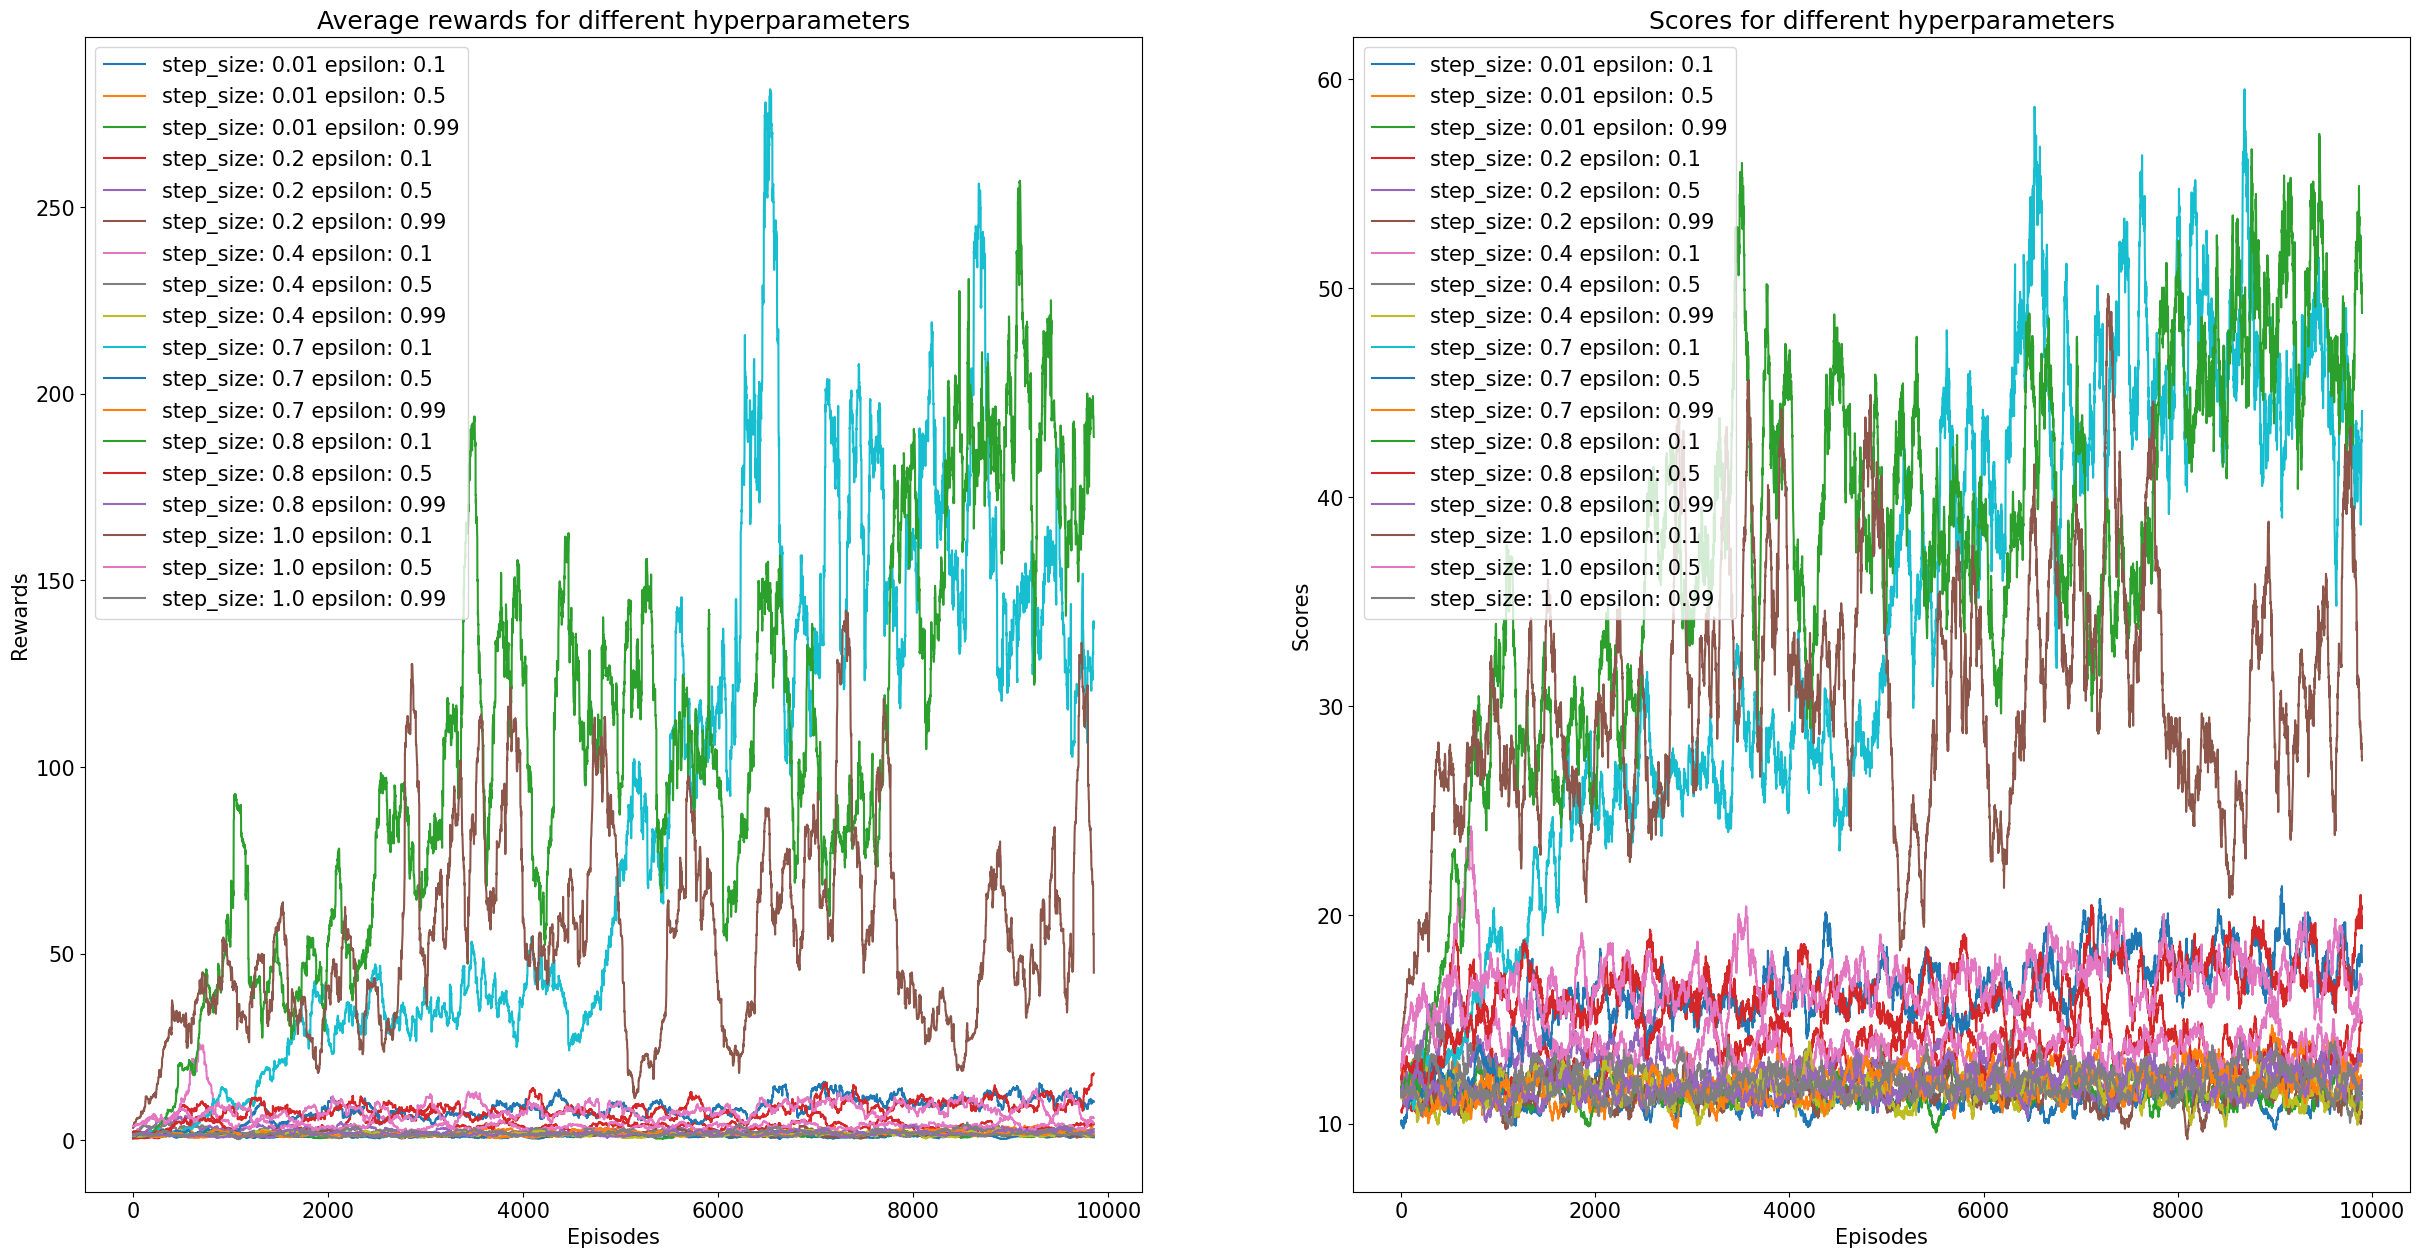

In [363]:
# plot all rewards 
def moving_average(x, k):
    return np.convolve(x, np.ones(k), 'valid') / k
# faire 2 plot 1 pour la reward une pour le score :
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
for params, rewards in rewards_dic.items():
    label = 'step_size: ' + str(params[0]) + ' epsilon: ' + str(params[1])
    ax[0].plot(moving_average(rewards, 150), label = label)
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Rewards')
    ax[0].legend()
    ax[0].set_title('Average rewards for different hyperparameters')
    ax[1].plot(moving_average(scores_dic[params], 100), label = label)
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Scores')
    ax[1].legend()
    ax[1].set_title('Scores for different hyperparameters')

In [364]:
best_params


(0.7, 0.1)

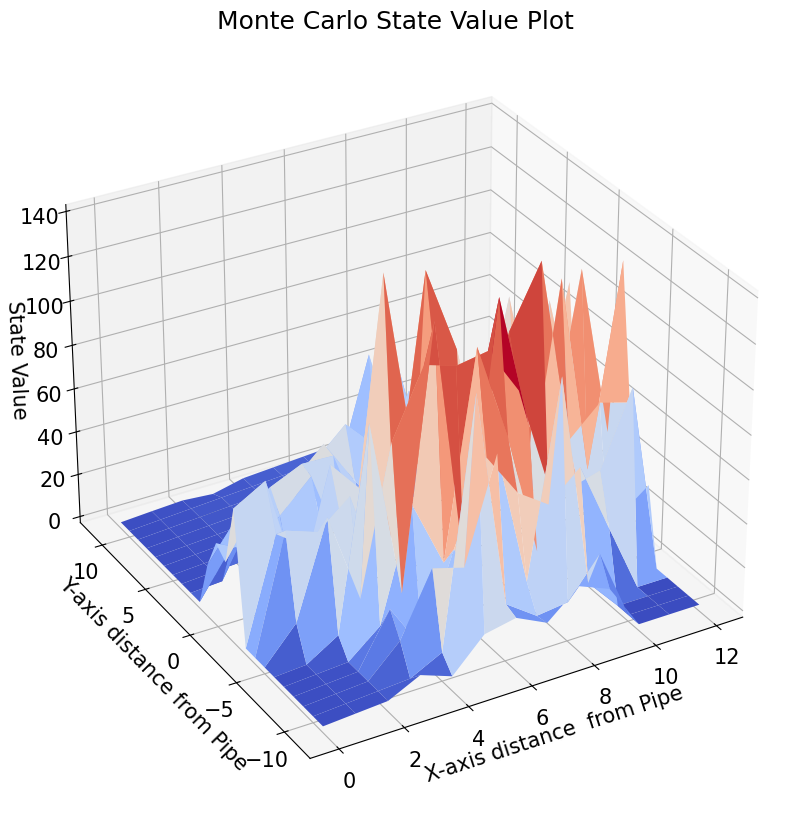

In [365]:
plot_fb_values(best_agent, 'Monte Carlo')

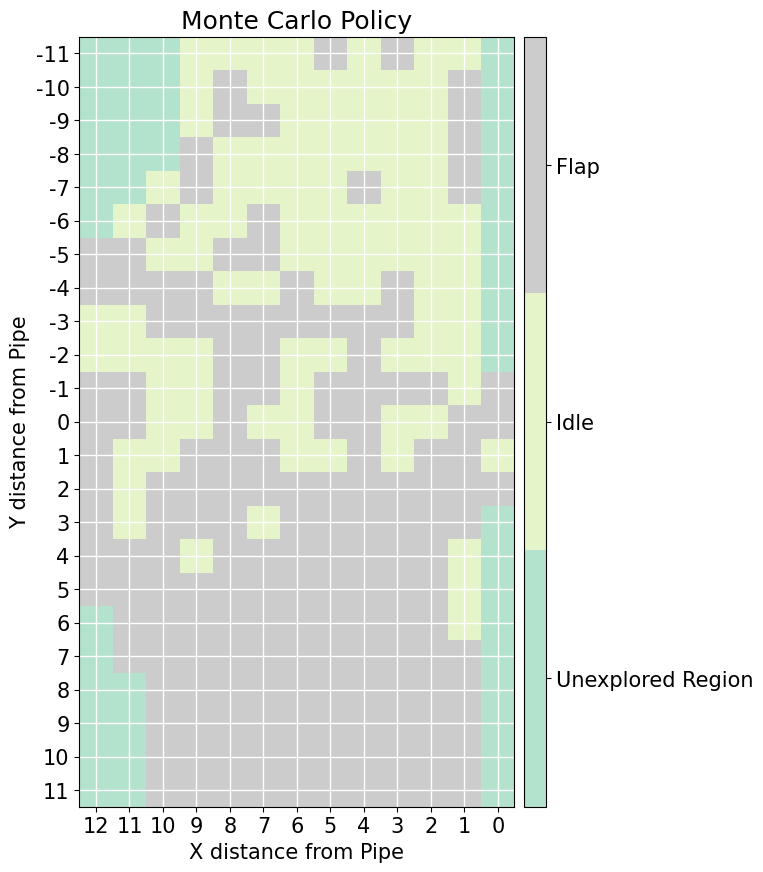

In [367]:
plot_policy(best_agent, 'Monte Carlo')

# B- Sarsa based agent

## 1- Implementation

In [298]:
class SarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info['eps_start']
        self.eps_decay = agent_init_info['eps_decay'] #Decay rate of epsilon
        self.eps_min = agent_init_info['eps_min'] 
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        
        #we map the sates to an index, since the states are represented by (x,y) coordinates
        self.state_dict = {}
        
    def agent_start(self, state):
        """Called when the episode starts after the environment starts.
        Args:
            state (int): The state from the environment's env_start function.
        Returns:
            action (int): The first action the agent takes.
        """
        # we decay epislon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min) 
        
        # if the state represented by (x,y) is not in the dictionary, add it to the dictionary
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]
        
        # Epsilon greedy.
        q_s = self.q[state_idx, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(q_s)
        self.previous_state_idx = state_idx
        self.previous_action = action
        return action
    
    def agent_step(self, reward, state):
        """Executes a single step in the agent-environment interaction.
        Args:
            reward (float): The reward received for the last action taken.
            state (int): The state observed by the agent after the last action.
        Returns:
            action (int): The action chosen by the agent for the current state.
        """
        # if the state represented by (x,y) is not in the dictionary, add it to the dictionary
        if state not in self.state_dict.keys():
            self.state_dict[state] = len(self.state_dict)
        state_idx = self.state_dict[state]

        # Epsilon greedy.
        q_s = self.q[state_idx,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(q_s)
     
        expected_q = 0
        q_max = np.max(q_s) 

        epsilon_prob = np.ones(self.num_actions) * self.epsilon / self.num_actions # for all actions by mean
        greedy_prob = (q_s == q_max) * (1 - self.epsilon) / np.sum(q_s == q_max)
        
        pi = epsilon_prob + greedy_prob # pi is the sum of epsilon probility per action plus greedy probability per max actions
        expected_q = np.sum(pi * q_s) # expected values
            
        self.q[self.previous_state_idx, self.previous_action] += self.step_size * (reward + self.discount * expected_q - 
                                                                       self.q[self.previous_state_idx, self.previous_action])
  
        self.previous_state_idx = state_idx
        self.previous_action = action
        return action
    
    def agent_end(self, reward):
        """Executes when the agent reaches the terminal state.
        Args:
            reward (float): The reward received upon entering the terminal state.
        """
        #we don't discount the value of the next state since it is the terminal state
        self.q[self.previous_state_idx, self.previous_action] += self.step_size * (reward - self.q[self.previous_state_idx, self.previous_action])
        
    def argmax(self, q_values):
        """Selects the action with the highest value using argmax with random tie-breaking.
            Args:
                q_values (Numpy array): Action values array.
            Returns:
                action (int): The action with the highest value.
            """

        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


In [299]:
def train_sarsa(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma):
    #initialize the environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    n_states = env.observation_space[0].n * env.observation_space[1].n 
    n_actions = env.action_space.n
    
    agent_info = {"num_actions": n_actions,"num_states":n_states,"eps_start":eps_start,"step_size":step_size,
                  "eps_decay": eps_decay,"eps_min": eps_min,"discount": gamma,"seed": 0}
    
    agent = SarsaAgent()
    agent.agent_init(agent_info)
    
    scores_history = []
    total_reward_history = []
    
    for _ in tqdm(range(num_episodes)):
      state = env.reset() #reset environment each episode
      state = state[0] # there is additional info in the state we only need the tuple (dx,dy) (first index)

      action = agent.agent_start(state)
      reward = 0
      total_reward = 0 
      while True:
        action = agent.agent_step(reward, state)
        next_state, reward, done,_, info = env.step(action) #take a step
        total_reward += reward 
        state = next_state
        
        if done:
          agent.agent_end(reward) 
          scores_history.append(info['score']) #keep the score at the end of the episode
          total_reward_history.append(total_reward) #keep the cumulative reward at the end of the episode 
          break
        
        #we force the agent to stop if it reaches the max score, because otherwise it will keep playing until it dies
        if info['score'] >= max_score:
          scores_history.append(info['score'])
          total_reward_history.append(total_reward)
          break

    return agent, scores_history,total_reward_history

## 2- Hyperparameter Tuning

In [324]:
agent, scores_history,total_reward_history = train_sarsa(10000, 4000, 0.1, 0.1, 0.9,0.1,0.1)

100%|██████████| 10000/10000 [00:02<00:00, 3433.70it/s]


In [337]:
step_size_range = [ 0.1, 0.2, 0.4, 0.8, 1]
epsilon_range = [0.1, 0.5, 0.99]
eps_min = 1e-4
eps_decay = 0.99
gamma = 0.95

def hyperparameter_search(env, agent, num_episodes, max_score =np.inf):
    rewards_dic = {}
    scores_dic = {}
    for eps_start in tqdm(epsilon_range):
            for step_size in step_size_range:
                    agent_, scores_history, total_reward_history = train_sarsa(num_episodes, max_score,eps_start, eps_decay, eps_min, step_size, gamma)
                    rewards_dic[(eps_start, step_size)] = total_reward_history
                    scores_dic[(eps_start, step_size)] = scores_history
    return rewards_dic, scores_dic

In [338]:
rewards_dic, scores_dic = hyperparameter_search(env, agent, 10000, 100)

100%|██████████| 3/3 [08:41<00:00, 173.77s/it]


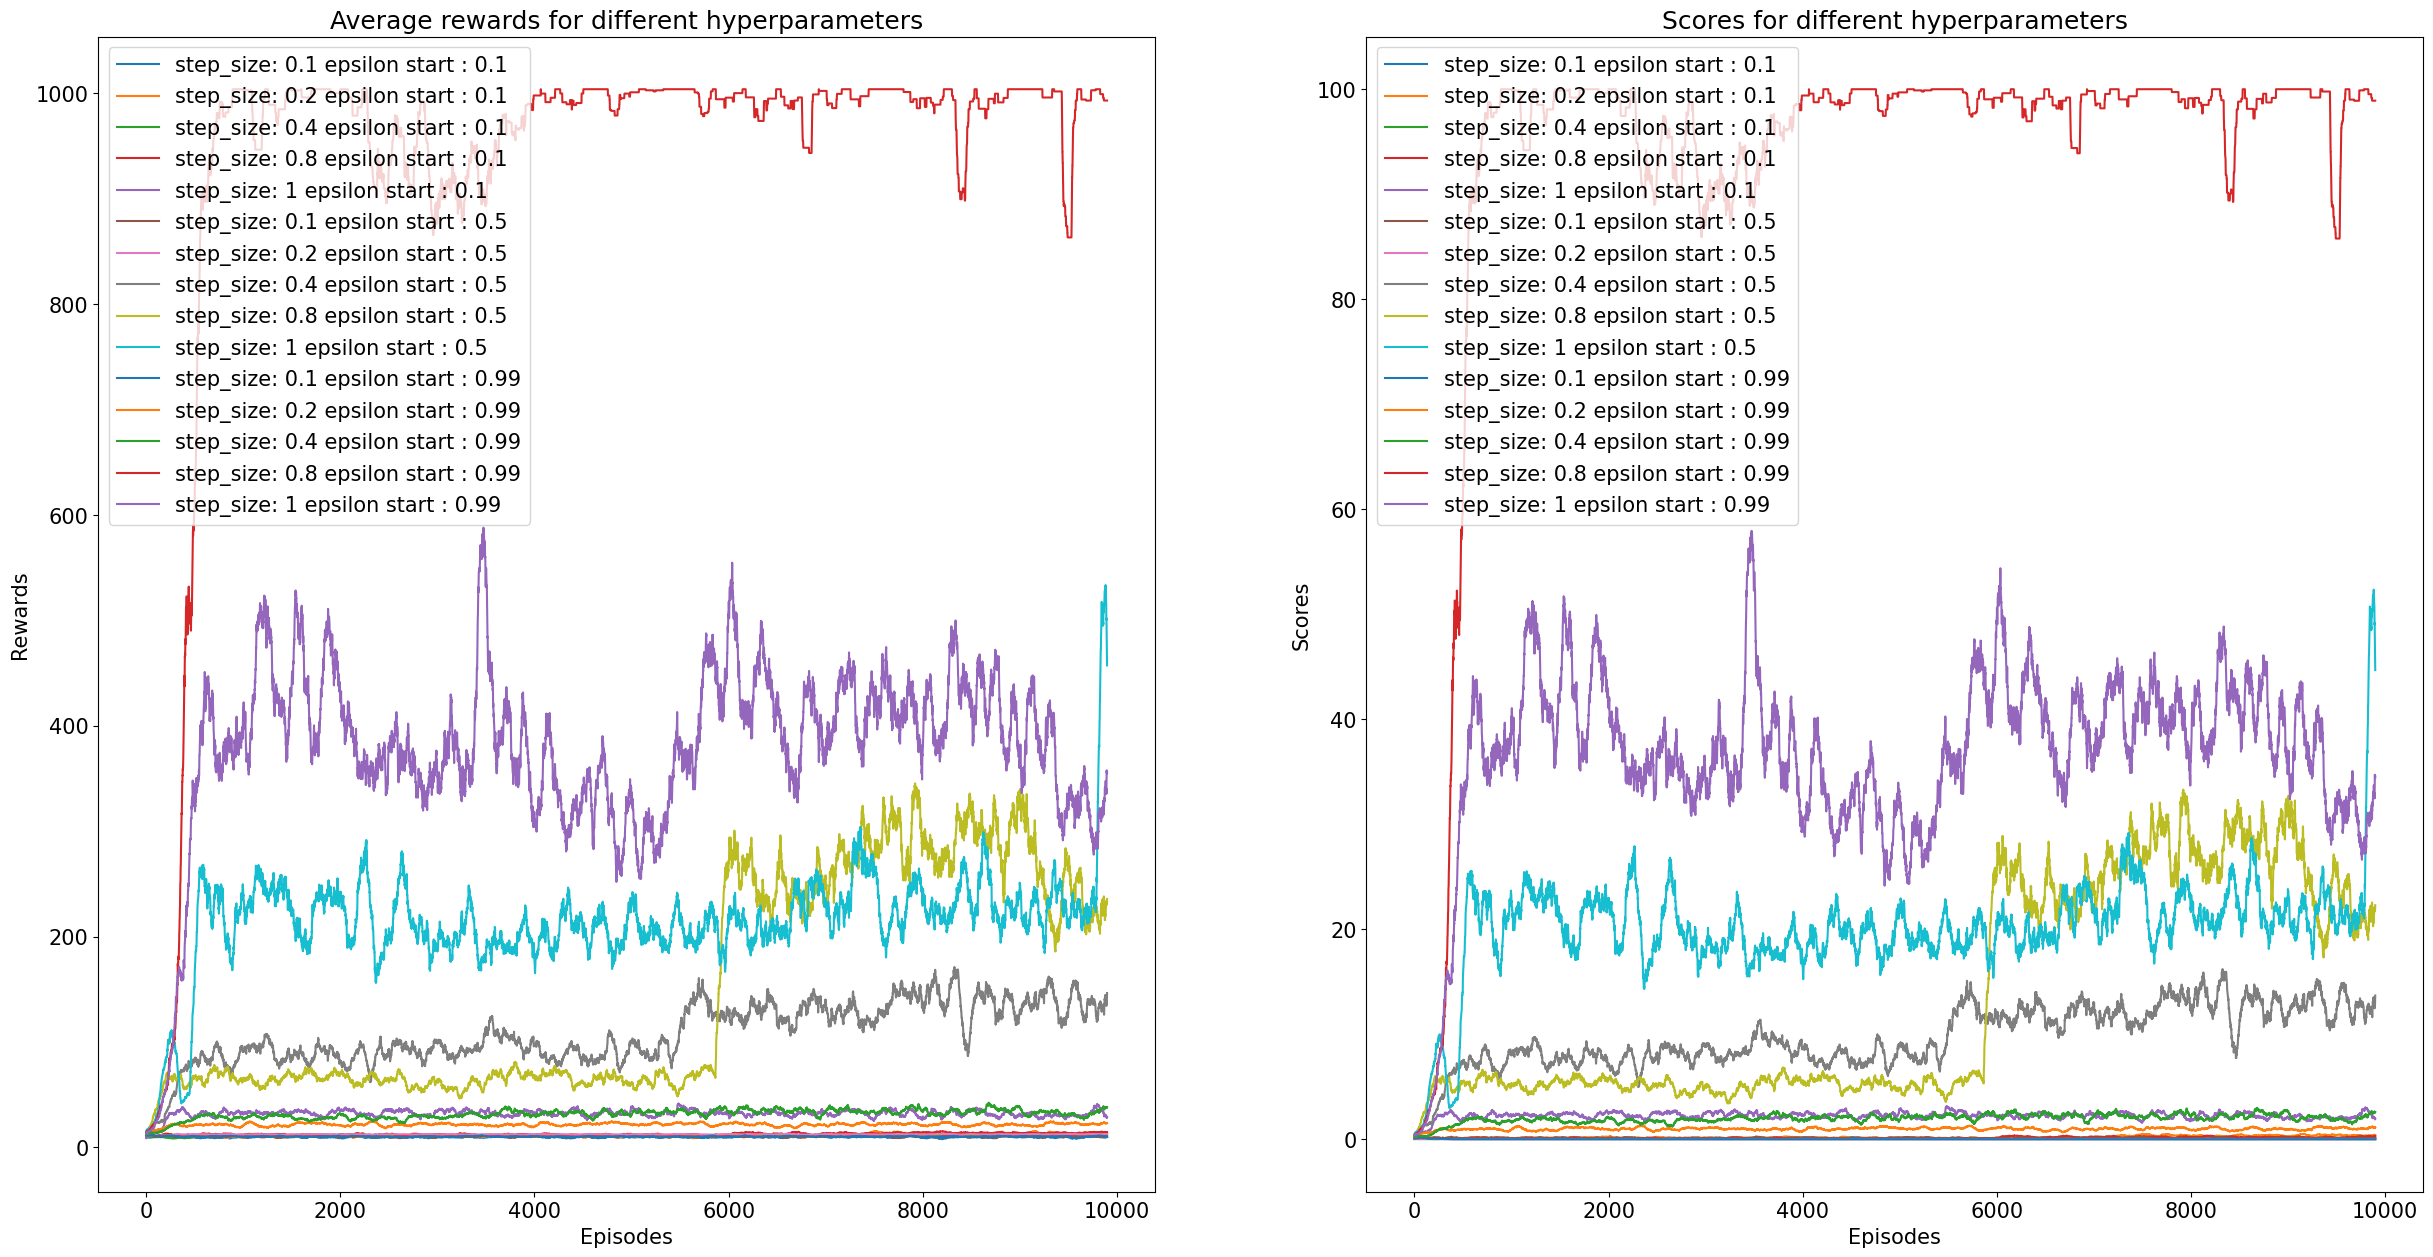

In [339]:
# plot all rewards and scores
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
for params, rewards in rewards_dic.items():
    label = 'step_size: ' + str(params[1]) + ' epsilon start : ' + str(params[0])
    ax[0].plot(moving_average(rewards, 100), label = label)
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Rewards')
    ax[0].legend()
    ax[0].set_title('Average rewards for different hyperparameters')
    ax[1].plot(moving_average(scores_dic[params], 100), label = label)
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Scores')
    ax[1].legend()
    ax[1].set_title('Scores for different hyperparameters')

## 3- Best Sarsa

In [371]:
best_params_sarsa = {'step_size': 0.8, 'eps_start':0.99, 'eps_min': 1e-4, 'eps_decay': 0.99, 'gamma': 0.95}
best_sarsa, scores_history, total_reward_history = train_sarsa(10000, 100, best_params_sarsa['eps_start'], best_params_sarsa['eps_decay'], best_params_sarsa['eps_min'], best_params_sarsa['step_size'], best_params_sarsa['gamma'])

100%|██████████| 10000/10000 [00:33<00:00, 302.27it/s]


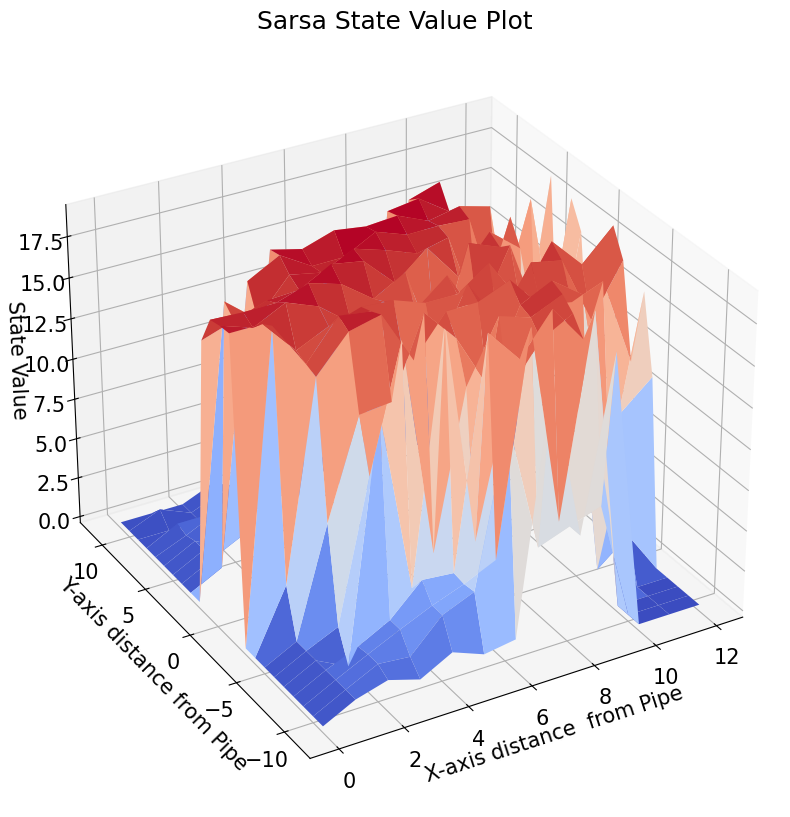

In [372]:
plot_fb_values(best_sarsa, "Sarsa")

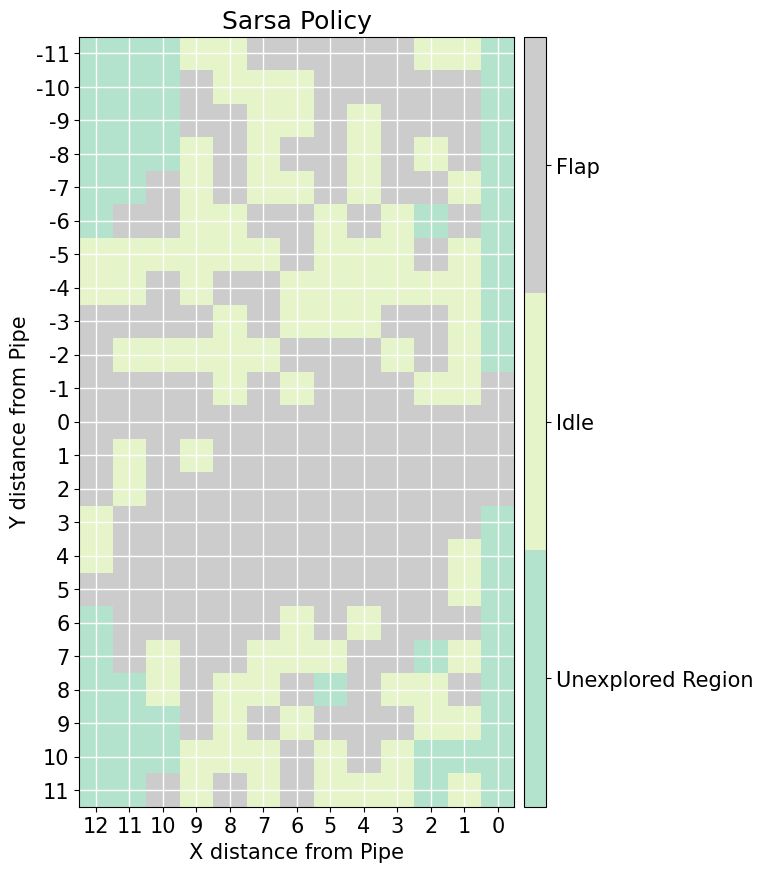

In [373]:
plot_policy(best_sarsa, "Sarsa")

# III- How well the agent perform on a different level configuration ?

In [382]:
max_score = np.max(scores_history)
print('Max score:', max_score)

Max score: 100


In [383]:

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 2)

In [411]:
def get_Z_with_unexplored(x, y,agent):
    if (x,y) in agent.state_dict.keys():
        return np.argmax(agent.q[agent.state_dict[(x,y)]])
    else:
        return -1 
    
def play(max_score = 1e3):
        obs = env.reset()
        obs = obs[0]
        while True:
            obs, reward, done, _, info = env.step(get_Z_with_unexplored(obs[0],obs[1],best_sarsa))

          # Render the game
        #   os.system("clear")
        #   sys.stdout.write(env.render())
        #   time.sleep(0.2) # FPS

          # If player is dead break
            if (done) | (info['score'] > int(max_score)):
                if (info['score'] > int(max_score)):
                    print(f"Sarsa Player has reached the Max Score of {int(max_score)}!")
                else:          
                    print(f"Sarsa Player Score: info['score'] - Did not reach Max set score of {int(max_score)} :(")
                    print(info['score'])
                break


        env.close()

In [473]:
play(10000)

Sarsa Player Score: info['score'] - Did not reach Max set score of 10000 :(
10
